# Kernel regression

**What you will learn today**: You will learn how to implement kernel regression. First we analyze a synthetic dataset: you will build the feature map associated with different kernels and we see how the learning performance can be different. As always after having understood the theoretical insights we step on to real-dataset problem: you can play using our dear friend sklearn to implement Kernel Ridge Regression, with a kernel of your choice.


# 1) KRR from scratch 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Let's do an usual routine for managing files in GColab 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/FofIL')


Remember first lecture?  Let us use pandas for handling synthetic dataset

In [ ]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/FofIL/dataTP7.csv')

In [ ]:
x,y = np.array(data['X']), np.array(data['Y'])

Let's see how it looks like

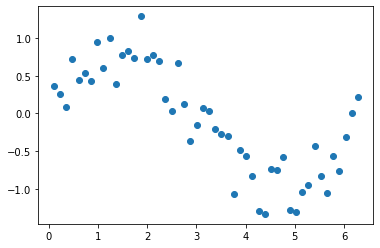

In [ ]:
plt.plot(x,y,'o') 

It does not seem a bad idea to use a polynomial fitting here. We have introduced in the theoretical lectures kernel methods: $$K(x,y) = {\phi(x)}^T{\phi(y)}$$

Let us pick for the first part of the analysis a feature map of the form:
$$ \phi_k^{(p)}(x) = x^k  \,\,\,\,\,\,\,\, k=1 \dots p $$

You may have studied this under the name *linear basis regression*.

The tools we need once we have mapped the datapoints in feature space are the usual one of linear regression as we know and all will be straight-forward.
We will study the behaviour as the degree $p$ varies, this will vary the complexity of the fitting model leading us to our usual bias-variance tradeoff consideration.

In [ ]:
def build_poly(x, degree,choice='none',gamma=1):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    x_pol = []
    
    for i in range(0,len(x)):
        x_pol_ele = []
        if choice == "rbf":
          x_pol_ele = np.exp(-x[i]*x[i]/gamma)*np.array([x[i]**j/(np.math.factorial(j)*np.math.sqrt(gamma**j)) for j in range(0,degree+1)])
        else:
          x_pol_ele = np.array([x[i]**j for j in range(0,degree+1)])
        x_pol.append(x_pol_ele)
        
    return np.array(x_pol)
def ridge_estimator(X, y, lamb):
    '''
    Implements the pseudo-inverse ridge estimator.
    '''
    n, d = X.shape
    if n>=d:
        aux = lamb*np.identity(d) + X.T@X
        what = np.linalg.inv(aux)@X.T@y
    else:
        aux = lamb*np.identity(n) + X@X.T 
        what = X.T@np.linalg.inv(aux)@y
    return what
def ridge_regression(y, X, lambda_):
    """implement ridge regression."""
    Xt = np.transpose(X)
    I = np.eye(len(Xt))
    w =  np.linalg.solve(Xt@X + (2*lambda_*len(y))*I,Xt@y)
    mse = (1/(2*len(y)))*np.sum((y-np.matmul(X,w))**2)
    return mse,w
def polynomial_regression(x,y,degrees,lambda_):
    fig, axs = plt.subplots(num,figsize=(15,15)) ; i =-1
    for degree in (degrees):
        i+=1   ; phi = build_poly(x, degree)
        
        mse , weights = ridge_regression(y, phi,lambda_)
        rmse = np.sqrt(2*mse)

        print("Processing {j}th experiment, degree={d}, rmse={loss}".format(
              j=i + 1, d=degree, loss=rmse))
        # print(weights)
        # plot fit
        # fhat = np.dot(phi,weights)
        xvals = np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)
        phi = build_poly(xvals, degree) ; fhat = np.dot(phi,weights)
        axs[i].plot(x,
            y, 'o',label=f'Degree={degree} -- Data')
        axs[i].plot(xvals,
            fhat,label=f'Fit')
        axs[i].set_ylim([-1.4,1.4])
        axs[i].legend()
    # plt.tight_layout()
    

In [ ]:
degrees = [5,  12, 20,50,80,120,160] ; lambda_ = 10e-6
num = len(degrees)

Processing 1th experiment, degree=5, rmse=0.2545435645040036
Processing 2th experiment, degree=12, rmse=0.24441564445032182
Processing 3th experiment, degree=20, rmse=0.24483499856312263
Processing 4th experiment, degree=50, rmse=0.2267243129675886
Processing 5th experiment, degree=80, rmse=0.21393322130512082
Processing 6th experiment, degree=120, rmse=0.21822142886732485
Processing 7th experiment, degree=160, rmse=0.2951185260264016


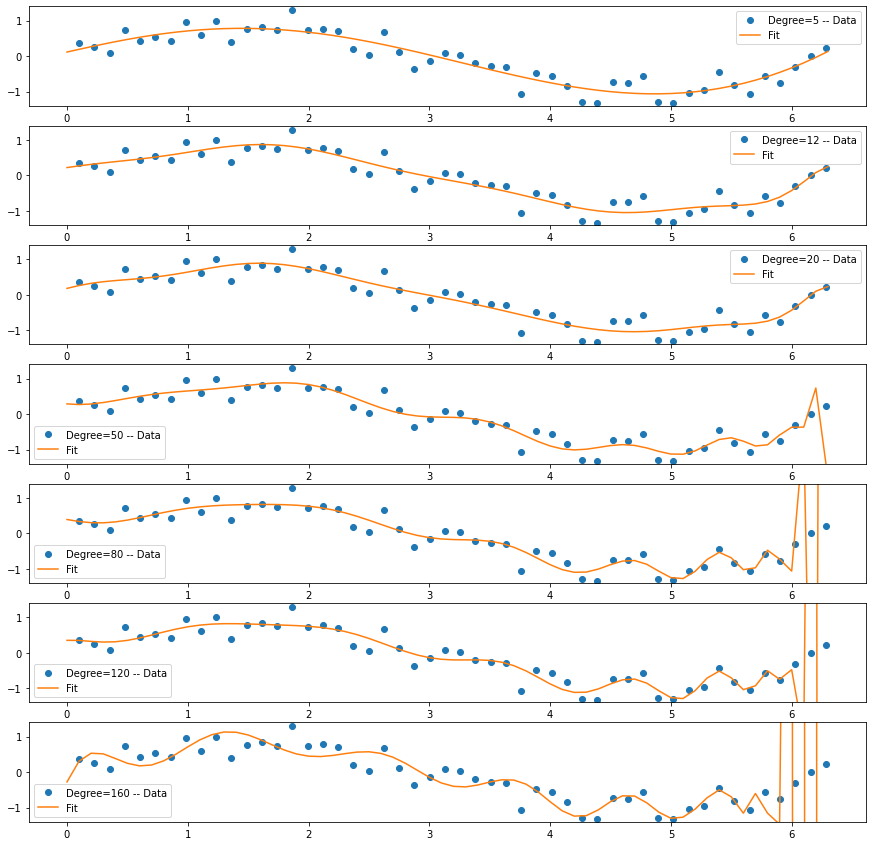

In [ ]:
polynomial_regression(x,y,degrees,lambda_)

We clearly see that by choosing a value of the degree too high we start to have bad fitting (i.e. overfitting). This feature map is not building a good kernel for studying the data.

It is interesting to understand if we can build another feature map, always in a polynomial fashion, that is able to having good learning rates.

First let's introduce some functions to split data in training and testing dataset to evaluate the performance of the model.

In [ ]:
def split_data(x, y, ratio, seed=1):
    # set seed
    np.random.seed(seed)
    # ***************************************************
    index = np.arange(0,len(x))
    index_train = np.random.choice(index, int(ratio*len(x)), replace=False)
    
    training_x = x[index_train]
    training_y = y[index_train]
    test_x = x[[i for i in range(len(x)) if i not in index_train]]
    test_y = y[[i for i in range(len(y)) if i not in index_train]]
    
    return training_x, training_y, test_x, test_y
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""

    training_x,training_y,test_x,test_y = split_data(x, y, ratio, seed)

    phi_train = build_poly(training_x, degree)
    phi_test = build_poly(test_x, degree)

    mse_train, weights = least_squares(training_y, phi_train)

    rmse_tr = np.sqrt(2*mse_train)
    mse_test = (1/(2*len(test_y)))*np.sum((test_y-np.matmul(phi_test,weights))**2)
    rmse_te = np.sqrt(2*mse_test)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


## Exercise
* Implement kernel regression with the feature map parametrized by $gamma$ which we encode with the codework "rbf".
* Study the behaviour as a function of $\lambda$ of the learning curves (test error and training error) and compare with what you would see with the previous feature map.
* What do you conclude?



# 2) Kernel regression on a realistic problem

We have seen how to build Kernel Ridge Regression (KRR) from scratch starting from the feature map. The idea to map datapoint in an higher dimensional space (i.e. kernel trick) can be used also in classification task. We will consider again our old friend MNIST, we will consider SVC (Support Vector Classification). We will see that, at stake with previous lecture, *SVC* will accept the parameter *kernel* to choose in which space mapping our datapoints.

In [ ]:
import time


from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
t0 = time.time()
train_size = 50000
test_size = 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


Automatically created module for IPython interactive environment


Let's plot an image to see how it looks like with plt.imshow.

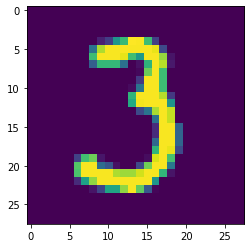

In [ ]:
plt.imshow(X[6543,:].reshape(28,28))

We shuffle the data and we do the test-train splitting.

In [ ]:
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
# pick training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size)

We preproccess the data and use StandardScaler to have zero mean and unit variance. Pay attention that we do that only on the training set!

In [ ]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Exercise**
- Repeat what you did in the previous lecture for a "linear"SVM classifier with a different kernel of your choice.
- Go and search the Python doc for SVM classifier. 
- Optimize the regularization parameter using CV. Use default value for the parameter which characterize the kernel (e.g. variance in the gaussian kernel)